# SCS_3666_018 Applied Natural Language Processing - Final Project
### Predicting ECB rate changes based on speeches leading up to monetary policy rate decision meetings

Speech data sourced from Kaggle:
https://www.kaggle.com/datasets/robertolofaro/ecb-speeches-1997-to-20191122-frequencies-dm

Rate change data sourced from ECB website:
https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html

##### Jonathan Fu

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

# import historical data for ECB meetings, decisions and rates
ECB_rate_decisions = pd.read_csv('ECB Decision Dates & Rate Changes.csv')

'''
def categorize_change(x):
    if x > 0:
        return "Increase"
    elif x < 0:
        return "Decrease"
    else:
        return "No change"

ECB_rate_decisions['Decision Direction'] = ECB_rate_decisions['Change (%)'].apply(categorize_change)
'''

# sort the dataframe by date
ECB_rate_decisions['Meeting Dates'] = pd.to_datetime(ECB_rate_decisions['Meeting Dates'], format='mixed',  errors='coerce')
ECB_rate_decisions = ECB_rate_decisions.sort_values(by='Meeting Dates').reset_index(drop=True)
ECB_rate_decisions

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Meeting Dates,Rate Change Date,Main refinancing operations - fixed rate tenders,Change (%),Direction
0,1999-01-13,NaN,3.00,NaN,NaN
1,1999-02-04,NaN,3.00,0.00,No Change
2,1999-03-04,NaN,3.00,0.00,No Change
3,1999-04-08,4/9/99,2.50,-0.50,Decrease
4,1999-05-06,NaN,2.50,0.00,No Change
...,...,...,...,...,...
245,2024-04-25,NaN,4.50,0.00,No Change
246,2024-06-06,6/12/24,4.25,-0.25,Decrease
247,2024-07-25,NaN,4.25,0.00,No Change
248,2024-09-05,9/18/24,3.65,-0.60,Decrease


In [3]:
Kaggle_ECB = pd.read_csv('export_datamart.csv')

# only include english releases and text based releases, exclude PDF files
Kaggle_ECB_eng = Kaggle_ECB.loc[Kaggle_ECB['what_language'].isin(['EN'])]
Kaggle_ECB_eng = Kaggle_ECB_eng[~Kaggle_ECB_eng['what_weblink'].str.contains('pdf')] # exclude links containing 'pdf'
Kaggle_ECB_eng = Kaggle_ECB_eng[~Kaggle_ECB_eng['what_weblink'].str.contains('.de.')] # remove links that contain '.de.' for non-english

# ECB was formed on Mar 1, 1999 - exclude all speeches before then
Kaggle_ECB_eng['when_speech'] = pd.to_datetime(Kaggle_ECB_eng['when_speech'], format='%m/%d/%Y')
Kaggle_ECB_eng = Kaggle_ECB_eng[~(Kaggle_ECB_eng['when_speech'] < '03/01/1999')]

# sort the dataframe by date
Kaggle_ECB_eng = Kaggle_ECB_eng.sort_values(by='when_speech').reset_index(drop=True)

In [4]:
Kaggle_ECB_eng

,speech_id,when_speech,who,what_title,what_frequencies,what_language,what_weblink,what_type
0,2748,1999-03-04,Willem F. Duisenberg,Introductory statement with Q&A,"{""euro"":45,""question"":33,""rate"":30,""duisenberg...",EN,https://www.ecb.europa.eu/press/pressconf/1999...,P
1,80,1999-03-08,Christian Noyer,First experiences with the euro,"{""monetary"":64,""euro"":51,""price"":48,""policy"":4...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S
2,81,1999-03-09,Tommaso Padoa-Schioppa,The euro: significance for Europe and beyond,"{""euro"":29,""currency"":20,""monetary"":15,""single...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S
3,82,1999-03-10,Eugenio Domingo Solans,The euro as a new world currency,"{""euro"":63,""currency"":29,""area"":23,""monetary"":...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S
4,83,1999-03-12,Willem F. Duisenberg,The Eurosystem's strategy for the euro,"{""monetary"":50,""stability"":35,""policy"":35,""pri...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S
...,...,...,...,...,...,...,...,...
3430,4710,2024-10-16,Christine Lagarde,Lessons from Ljubljana in uncertain times,"{""slovenia"":22,""europe"":11,""european"":6,""econo...",EN,https://www.ecb.europa.eu/press/key/date/2024/...,S
3431,4711,2024-10-17,"Christine Lagarde,\nLuis de Guindos",PRESS CONFERENCE,"{""inflation"":70,""data"":30,""policy"":23,""rate"":2...",EN,https://www.ecb.europa.eu/press/press_conferen...,P
3432,4718,2024-10-24,Matthias Rumpf,Cross-border deposits: growing trust in the eu...,"{""deposits"":21,""euro"":15,""area"":14,""countries""...",EN,https://www.ecb.europa.eu/press/blog/date/2024...,B
3433,4715,2024-10-24,Philip R. Lane,Underlying inflation: an update,"{""ecb"":2,""speech"":1,""dynamics"":1,""bank"":1,""res...",EN,https://www.ecb.europa.eu/press/key/date/2024/...,S


In [5]:
# merge the ECB speech/press release dataframe with the ECB meeting date & rate decision dataframe
# create temp column to match meetings that occured after speech/press release dates
joined = pd.merge_asof(Kaggle_ECB_eng, ECB_rate_decisions, left_on=['when_speech'], right_on='Meeting Dates', direction='forward')
joined['is_col2_earlier'] = joined['when_speech'] > joined['Meeting Dates']
joined['same_date'] = joined['when_speech'] == joined['Meeting Dates']
joined = joined.dropna(subset=['Direction'])
joined

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,speech_id,when_speech,who,what_title,what_frequencies,what_language,what_weblink,what_type,Meeting Dates,Rate Change Date,Main refinancing operations - fixed rate tenders,Change (%),Direction,is_col2_earlier,same_date
0,2748,1999-03-04,Willem F. Duisenberg,Introductory statement with Q&A,"{""euro"":45,""question"":33,""rate"":30,""duisenberg...",EN,https://www.ecb.europa.eu/press/pressconf/1999...,P,1999-03-04,NaN,3.0,0.00,No Change,False,True
1,80,1999-03-08,Christian Noyer,First experiences with the euro,"{""monetary"":64,""euro"":51,""price"":48,""policy"":4...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False
2,81,1999-03-09,Tommaso Padoa-Schioppa,The euro: significance for Europe and beyond,"{""euro"":29,""currency"":20,""monetary"":15,""single...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False
3,82,1999-03-10,Eugenio Domingo Solans,The euro as a new world currency,"{""euro"":63,""currency"":29,""area"":23,""monetary"":...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False
4,83,1999-03-12,Willem F. Duisenberg,The Eurosystem's strategy for the euro,"{""monetary"":50,""stability"":35,""policy"":35,""pri...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3429,4709,2024-10-09,"Dennis Essers, Laura Lebastard, Michele Manci...",Critical inputs from China: how vulnerable are...,"{""countries"":22,""added"":15,""supply"":12,""chart""...",EN,https://www.ecb.europa.eu/press/blog/date/2024...,B,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,False
3430,4710,2024-10-16,Christine Lagarde,Lessons from Ljubljana in uncertain times,"{""slovenia"":22,""europe"":11,""european"":6,""econo...",EN,https://www.ecb.europa.eu/press/key/date/2024/...,S,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,False
3431,4711,2024-10-17,"Christine Lagarde,\nLuis de Guindos",PRESS CONFERENCE,"{""inflation"":70,""data"":30,""policy"":23,""rate"":2...",EN,https://www.ecb.europa.eu/press/press_conferen...,P,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,False
3432,4718,2024-10-24,Matthias Rumpf,Cross-border deposits: growing trust in the eu...,"{""deposits"":21,""euro"":15,""area"":14,""countries""...",EN,https://www.ecb.europa.eu/press/blog/date/2024...,B,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,True


In [6]:
# count the number of interest rate directional changes
print(joined['Direction'].value_counts())

Direction
No Change    2888
Decrease      294
Increase      252
Name: count, dtype: int64


In [7]:
# create a separate dataframe to identify speeches or press releases that happened on the same day as policy meeting date
same_day_df = joined[joined['same_date'] == True]
same_day_df

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,speech_id,when_speech,who,what_title,what_frequencies,what_language,what_weblink,what_type,Meeting Dates,Rate Change Date,Main refinancing operations - fixed rate tenders,Change (%),Direction,is_col2_earlier,same_date
0,2748,1999-03-04,Willem F. Duisenberg,Introductory statement with Q&A,"{""euro"":45,""question"":33,""rate"":30,""duisenberg...",EN,https://www.ecb.europa.eu/press/pressconf/1999...,P,1999-03-04,NaN,3.00,0.00,No Change,False,True
8,2749,1999-04-08,Willem F. Duisenberg,Introductory statement with Q&A,"{""euro"":39,""rate"":35,""today"":24,""interest"":22,...",EN,https://www.ecb.europa.eu/press/pressconf/1999...,P,1999-04-08,4/9/99,2.50,-0.50,Decrease,False,True
17,2750,1999-05-06,Willem F. Duisenberg,Introductory statement with Q&A,"{""euro"":29,""question"":17,""developments"":16,""ra...",EN,https://www.ecb.europa.eu/press/pressconf/1999...,P,1999-05-06,NaN,2.50,0.00,No Change,False,True
27,110,1999-06-03,Willem F. Duisenberg,Developments in the Financial Sector in Europe...,"{""markets"":40,""euro"":38,""area"":30,""financial"":...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-06-03,NaN,2.50,0.00,No Change,False,True
46,2753,1999-09-09,Willem F. Duisenberg,Introductory statement with Q&A,"{""monetary"":35,""question"":33,""year"":31,""euro"":...",EN,https://www.ecb.europa.eu/press/pressconf/1999...,P,1999-09-09,NaN,2.50,0.00,No Change,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3327,4549,2024-01-25,"Christine Lagarde, Luis de Guindos",PRESS CONFERENCE,"{""inflation"":49,""question"":25,""data"":25,""polic...",EN,https://www.ecb.europa.eu/press/pressconf/2024...,P,2024-01-25,NaN,4.50,0.00,No Change,False,True
3345,4582,2024-03-07,"Christine Lagarde,\nLuis de Guindos",PRESS CONFERENCE,"{""inflation"":63,""cent"":27,""growth"":20,""policy""...",EN,https://www.ecb.europa.eu/press/pressconf/2024...,P,2024-03-07,NaN,4.50,0.00,No Change,False,True
3379,4644,2024-06-06,"Christine Lagarde, Luis de Guindos",PRESS CONFERENCE,"{""inflation"":61,""data"":42,""cent"":28,""policy"":2...",EN,https://www.ecb.europa.eu/press/press_conferen...,P,2024-06-06,6/12/24,4.25,-0.25,Decrease,False,True
3432,4718,2024-10-24,Matthias Rumpf,Cross-border deposits: growing trust in the eu...,"{""deposits"":21,""euro"":15,""area"":14,""countries""...",EN,https://www.ecb.europa.eu/press/blog/date/2024...,B,2024-10-24,10/23/24,3.40,-0.25,Decrease,False,True


In [8]:
# count the number of interest rate directional changes
print(same_day_df['Direction'].value_counts())

Direction
No Change    208
Decrease      19
Increase      14
Name: count, dtype: int64


In [9]:
#Kaggle_ECB_eng['when_speech'].tolist()

In [10]:
print(Kaggle_ECB_eng.shape)

(3435, 8)


In [11]:
links = Kaggle_ECB_eng['what_weblink'].tolist()
links[0]

'https://www.ecb.europa.eu/press/pressconf/1999/html/is990304.en.html'

In [12]:
# screen scrape text data from ECB website

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

def joined_process_links():
  with tqdm(total=len(joined), desc="Processing links", unit="link") as pbar:
      for index, row in joined.iterrows():
          link = row['what_weblink']
          #print("Link:", link)

          page = requests.get(link, verify=True)
          soup = BeautifulSoup(page.content, "html.parser")

          # look for only content in the 'main section'
          main_content = soup.find('main')

          sections = []

          # extract plain text from body/section
          section_elements = main_content.find_all('div', class_='section')
          for section_element in section_elements:
              section_text = section_element.get_text(strip=True)
              sections.append(section_text)
              #print(section_text)

          article_text = " ".join(sections) # convert list into string before appending to articles list
          joined.at[index, 'extracted_text'] = article_text

          pbar.update(1)


In [31]:
if os.path.exists('joined.parquet.gzip'):
  joined = pd.read_parquet('joined.parquet.gzip')
else:
  joined_process_links()
  joined.to_parquet('joined.parquet.gzip', compression='gzip')


In [32]:
joined

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,speech_id,when_speech,who,what_title,what_frequencies,what_language,what_weblink,what_type,Meeting Dates,Rate Change Date,Main refinancing operations - fixed rate tenders,Change (%),Direction,is_col2_earlier,same_date,extracted_text
0,2748,1999-03-04,Willem F. Duisenberg,Introductory statement with Q&A,"{""euro"":45,""question"":33,""rate"":30,""duisenberg...",EN,https://www.ecb.europa.eu/press/pressconf/1999...,P,1999-03-04,None,3.0,0.00,No Change,False,True,"Willem F. Duisenberg, President of the Europea..."
1,80,1999-03-08,Christian Noyer,First experiences with the euro,"{""monetary"":64,""euro"":51,""price"":48,""policy"":4...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False,"Speech by Christian Noyer, Vice-President of t..."
2,81,1999-03-09,Tommaso Padoa-Schioppa,The euro: significance for Europe and beyond,"{""euro"":29,""currency"":20,""monetary"":15,""single...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False,Speech by Tommaso Padoa-Schioppa Member of the...
3,82,1999-03-10,Eugenio Domingo Solans,The euro as a new world currency,"{""euro"":63,""currency"":29,""area"":23,""monetary"":...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False,"Eugenio Domingo Solans, Member of the Executiv..."
4,83,1999-03-12,Willem F. Duisenberg,The Eurosystem's strategy for the euro,"{""monetary"":50,""stability"":35,""policy"":35,""pri...",EN,https://www.ecb.europa.eu/press/key/date/1999/...,S,1999-04-08,4/9/99,2.5,-0.50,Decrease,False,False,"Speech by Dr. Willem F. Duisenberg, President ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3429,4709,2024-10-09,"Dennis Essers, Laura Lebastard, Michele Manci...",Critical inputs from China: how vulnerable are...,"{""countries"":22,""added"":15,""supply"":12,""chart""...",EN,https://www.ecb.europa.eu/press/blog/date/2024...,B,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,False,"9 October 2024By Dennis Essers, Laura Lebastar..."
3430,4710,2024-10-16,Christine Lagarde,Lessons from Ljubljana in uncertain times,"{""slovenia"":22,""europe"":11,""european"":6,""econo...",EN,https://www.ecb.europa.eu/press/key/date/2024/...,S,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,False,"Speech by Christine Lagarde, President of the ..."
3431,4711,2024-10-17,"Christine Lagarde,\nLuis de Guindos",PRESS CONFERENCE,"{""inflation"":70,""data"":30,""policy"":23,""rate"":2...",EN,https://www.ecb.europa.eu/press/press_conferen...,P,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,False,"Christine Lagarde, President of the ECB,Luis d..."
3432,4718,2024-10-24,Matthias Rumpf,Cross-border deposits: growing trust in the eu...,"{""deposits"":21,""euro"":15,""area"":14,""countries""...",EN,https://www.ecb.europa.eu/press/blog/date/2024...,B,2024-10-24,10/23/24,3.4,-0.25,Decrease,False,True,24 October 2024 [Paragraph five and six of th...


In [33]:
dates = joined['when_speech'].tolist()
titles = joined['what_title'].tolist()
print(len(dates))
print(len(titles))

3434
3434


In [34]:
articles = joined['extracted_text'].tolist()

In [35]:
len(articles)

3434

In [36]:
# ensure all lists have the same length before joining as dictionary/json file
assert len(dates) == len(titles) == len(articles), "All lists must have the same length"

In [19]:
# check first item in dictionary called data
#data[0]
#data[0]["content"]

In [20]:
# check articles first item in list
#articles[0]

In [37]:
# check to ensure all articles are individual strings in the list
for index, article in enumerate(articles):
    if not isinstance(article, str):
        print(f"Element {index} is not a string.")

## Exploratory Data Analysis

### Text Normalizer

In [38]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
from nltk import word_tokenize, pos_tag
import unicodedata
import numpy as np
import re

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin

class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english'):
        self.language = language
        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def normalize(self, document):
        tagged_tokens = pos_tag(word_tokenize(document))  # Tokenize and tag
        normalized_text = [
            self.lemmatize(re.sub(r'\W+', '', token), tag).lower()
            for token, tag in tagged_tokens
            if not self.is_punct(token) and not self.is_stopword(token)
        ]
        #print("Normalized text:", " ".join(normalized_text))
        return normalized_text

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        return [self.normalize(document) for document in tqdm(documents, desc="Normalizing Documents")]

In [42]:
normalizer = TextNormalizer()


In [43]:
import pickle

normalized_speeches = []
if os.path.exists('normalized_speeches.pkl'):
  with open('normalized_speeches.pkl', 'rb') as f:
    normalized_speeches = pickle.load(f)
else:
  normalized_speeches = normalizer.transform(articles)
  with open('normalized_speeches.pkl', 'wb') as f:
    pickle.dump(normalized_speeches, f)

In [44]:
print(normalized_speeches[0])

['willem', 'f', 'duisenberg', 'president', 'european', 'central', 'bank', 'thursday', '4', 'march', '1999ladies', 'gentleman', 'vicepresident', 'today', 'report', 'outcome', 'today', 's', 'meeting', 'governing', 'council', 'general', 'council', 'european', 'central', 'banklet', 'start', 'governing', 'council', 's', 'discussion', 'onrecent', 'economic', 'development', 'decision', 'governing', 'council', 'take', 'today', 'field', 'monetary', 'policyafter', 'comprehensive', 'careful', 'examination', 'recent', 'trend', 'ongoing', 'evaluation', 'economic', 'outlook', 'euro', 'area', 'economy', 'consensus', 'risk', 'identify', 'earlier', 'particular', 'regard', 'real', 'gdp', 'growth', 'materialise', 'fourth', 'quarter', '1998', 'also', 'consensus', 'impact', 'development', 'balance', 'risk', 'price', 'stability', 'would', 'need', 'examine', 'context', 'monetary', 'policy', 'strategy', 'adopt', 'eurosystem', 'juncture', 'take', 'account', 'information', 'available', 'governing', 'council', '

In [45]:
normalized_speeches_join = [" ".join(tokens) for tokens in normalized_speeches]
#normalized_speeches_join[:1]

### Frequency distribution of the corpus after stopwords removal

In [39]:
#!pip install yellowbrick

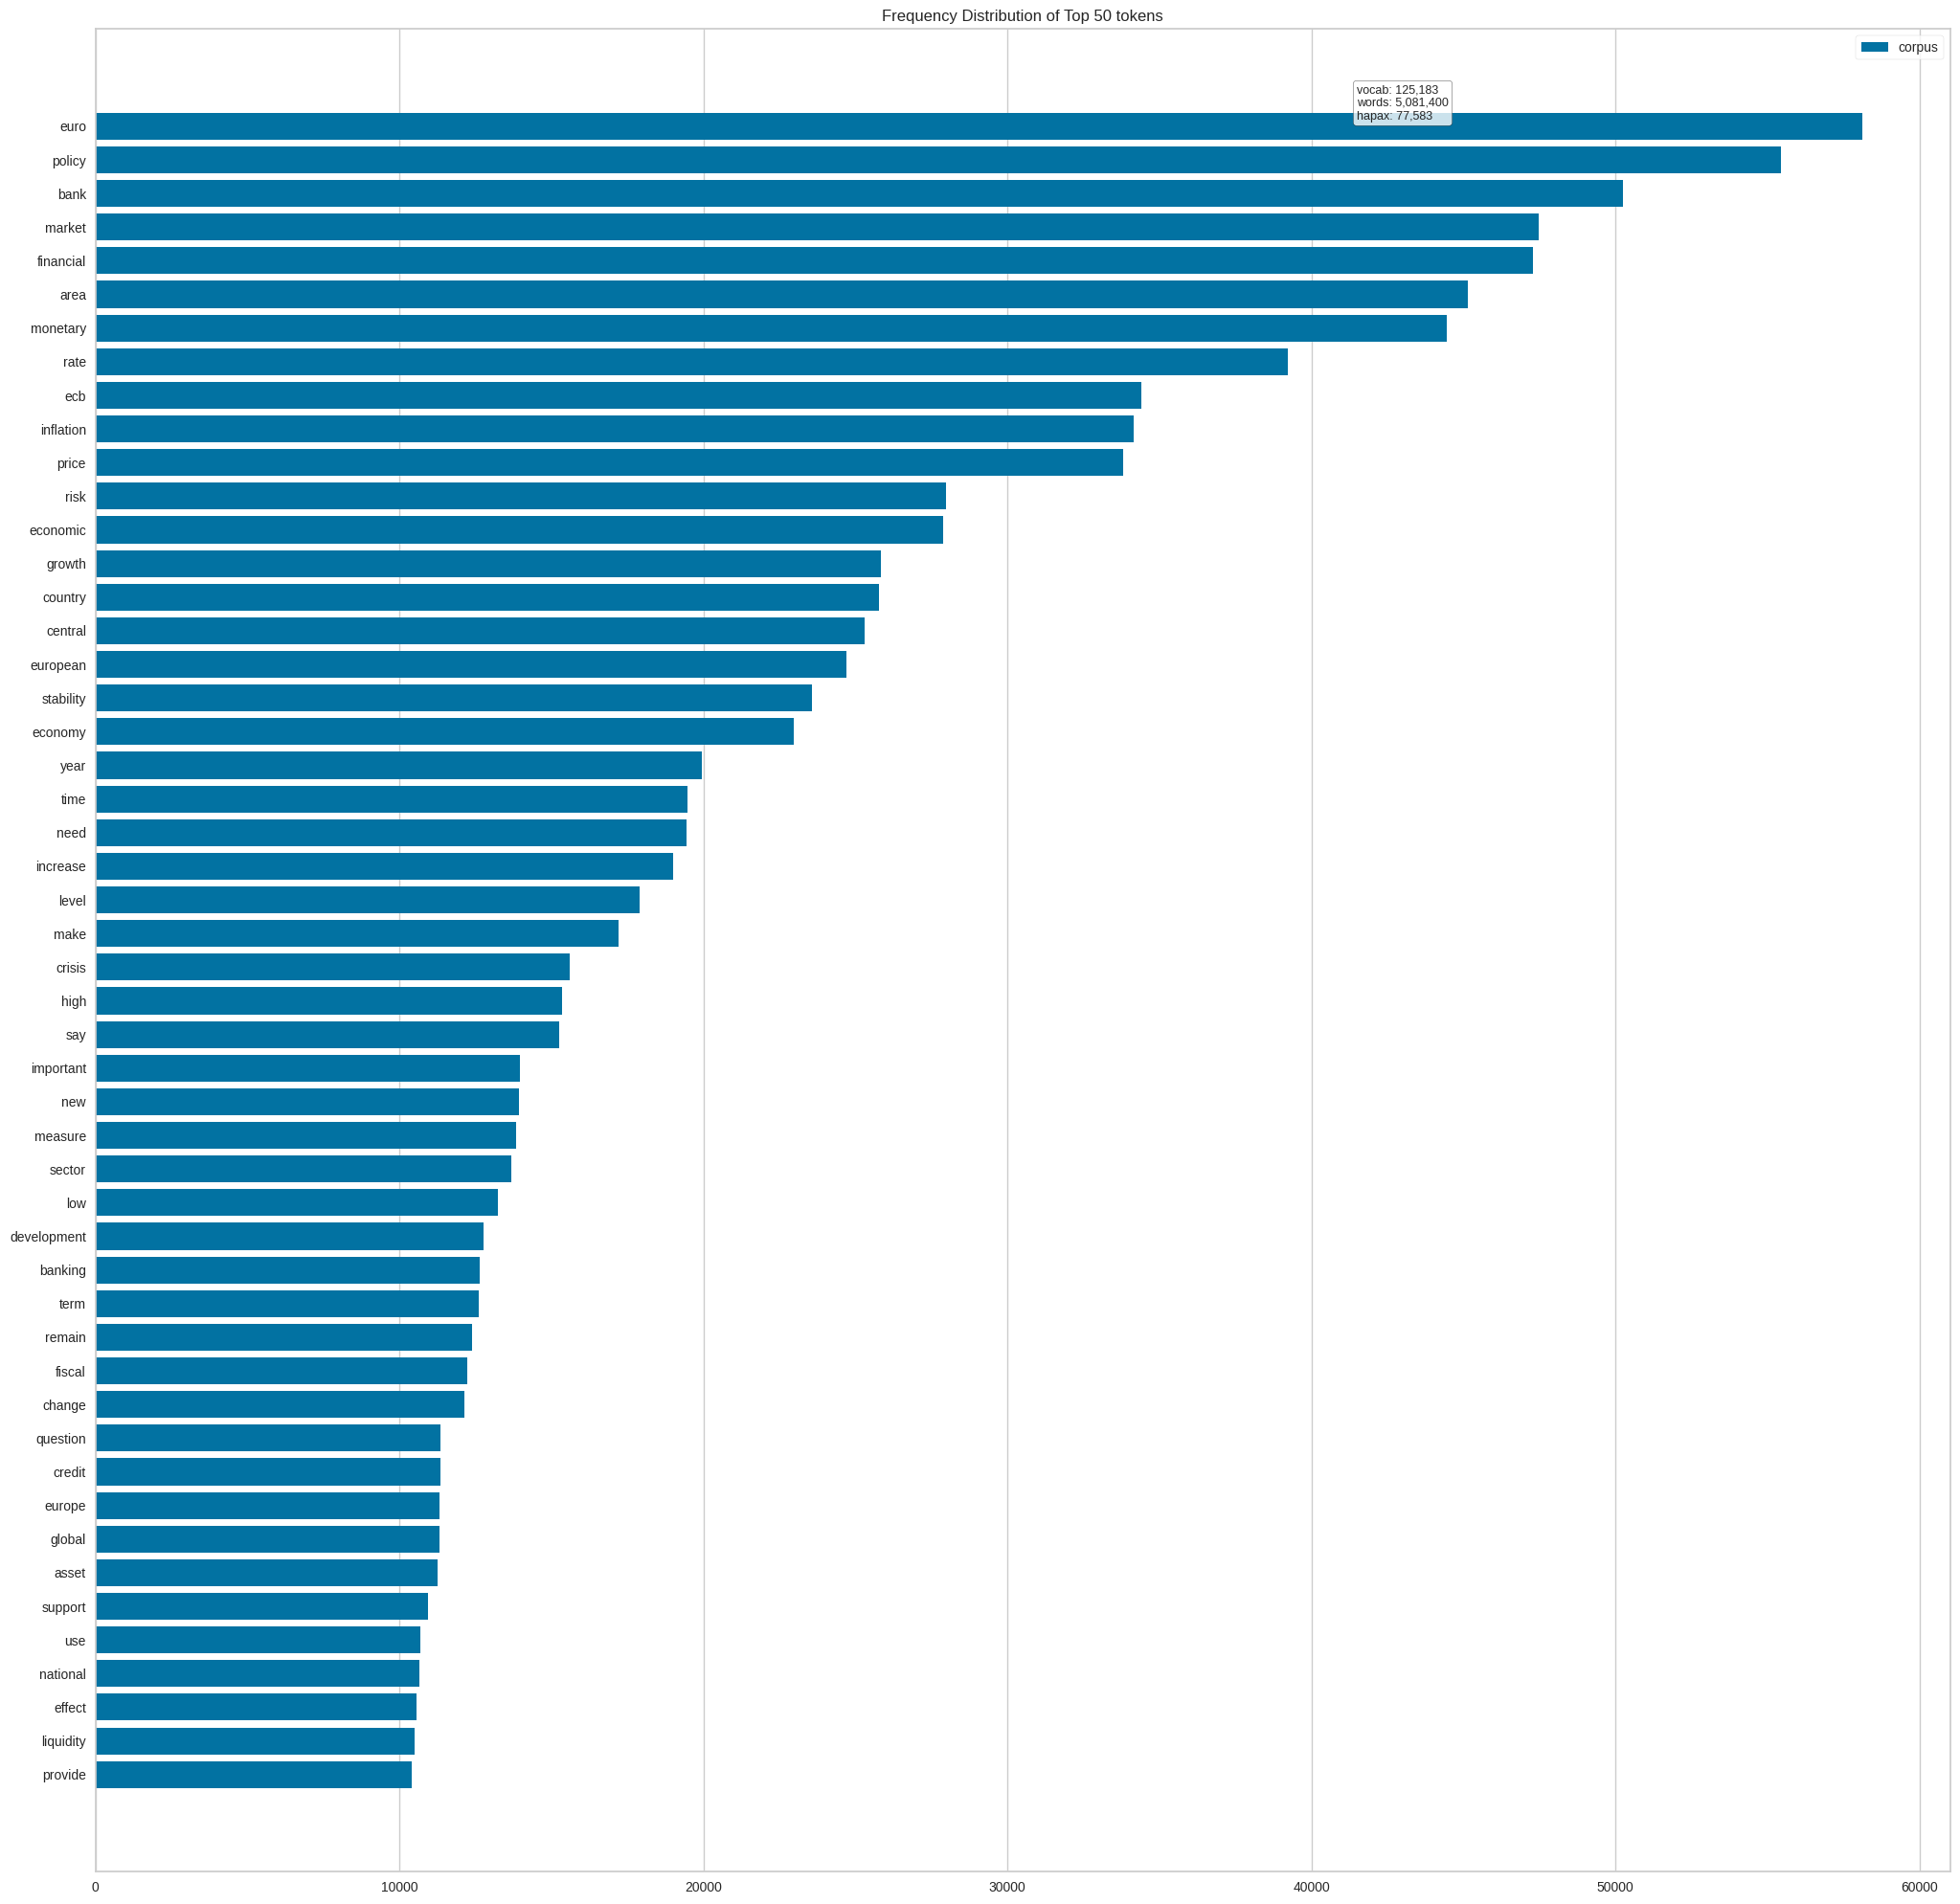

CPU times: user 7.03 s, sys: 372 ms, total: 7.41 s
Wall time: 7.45 s


In [40]:
%%time
from yellowbrick.text.freqdist import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

# Join all speeches together into one string
all_speechs_one_list = [' '.join(doc) for doc in normalized_speeches]

def freq_distribution(data):
    # Visualize frequency distribution of top 50 tokens
    vectorizer = CountVectorizer(stop_words = 'english')
    docs = vectorizer.fit_transform(data)
    features = vectorizer.get_feature_names_out()

    plt.figure(figsize=(25,25), facecolor='white')
    visualizer = FreqDistVisualizer(features)
    visualizer.fit(docs)
    visualizer.poof()

freq_distribution(all_speechs_one_list)

### Gensim LDA visualization

In [41]:
%%time
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import TfidfModel, LdaModel
from gensim.corpora import Dictionary
from sklearn.pipeline import Pipeline

# Ensure documents are tokenized
tokenized_docs = [doc.split() for doc in normalized_speeches_join]

class GensimTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, dirpath=".", tofull=False):
        self._lexicon_path = os.path.join(dirpath, "corpus.dict")
        self._tfidf_path = os.path.join(dirpath, "tfidf.model")
        self.lexicon = None
        self.tfidf = None
        self.tofull = tofull
        self.load()

    def load(self):
        if os.path.exists(self._lexicon_path):
            self.lexicon = Dictionary.load(self._lexicon_path)
        if os.path.exists(self._tfidf_path):
            self.tfidf = TfidfModel.load(self._tfidf_path)

    def save(self):
        self.lexicon.save(self._lexicon_path)
        self.tfidf.save(self._tfidf_path)

    def fit(self, documents, labels=None):
        self.lexicon = Dictionary(documents)
        self.tfidf = TfidfModel([self.lexicon.doc2bow(doc) for doc in documents], id2word=self.lexicon)
        self.save()
        return self

    def transform(self, documents):
        return [self.tfidf[self.lexicon.doc2bow(doc)] for doc in documents]

class GensimLdaModel:
    def __init__(self, n_topics=50):
        self.n_topics = n_topics
        self.model = None

    def fit(self, tfidf_corpus, id2word):
        self.model = LdaModel(tfidf_corpus, num_topics=self.n_topics, id2word=id2word)
        return self

    def transform(self, tfidf_corpus):
        return [self.model[doc] for doc in tfidf_corpus]

class GensimTopicModels:
    def __init__(self, n_topics=50):
        self.n_topics = n_topics
        self.pipeline = Pipeline([
            # ('norm', TextNormalizer(output="list")),  # Add normalizer if required
            ('vect', GensimTfidfVectorizer()),
            ('lda', GensimLdaModel(n_topics=n_topics))
        ])

    def fit(self, documents):
        vectorized_docs = self.pipeline.named_steps['vect'].fit_transform(documents)
        self.pipeline.named_steps['lda'].fit(vectorized_docs, self.pipeline.named_steps['vect'].lexicon)
        return self.pipeline

    def show_topics(self, num_words=10):
        lda_model = self.pipeline.named_steps['lda'].model
        return lda_model.show_topics(num_words=num_words)

# Fit the model
topic_model_gensim = GensimTopicModels(n_topics=3)
topic_model_gensim.fit(tokenized_docs)

# View topics
print(topic_model_gensim.show_topics())

[(0, '0.001*"s" + 0.000*"nt" + 0.000*"inflation" + 0.000*"ve" + 0.000*"question" + 0.000*"say" + 0.000*"rate" + 0.000*"think" + 0.000*"fiscal" + 0.000*"reform"'), (1, '0.001*"inflation" + 0.000*"digital" + 0.000*"wage" + 0.000*"rate" + 0.000*"energy" + 0.000*"statistic" + 0.000*"chart" + 0.000*"price" + 0.000*"growth" + 0.000*"data"'), (2, '0.001*"inflation" + 0.001*"pandemic" + 0.001*"climate" + 0.001*"digital" + 0.001*"payment" + 0.001*"purchase" + 0.001*"rate" + 0.001*"crisis" + 0.000*"s" + 0.000*"fiscal"')]
CPU times: user 29.9 s, sys: 856 ms, total: 30.7 s
Wall time: 31.4 s


In [42]:
%%time
import pyLDAvis
import pyLDAvis.gensim

# Getting the fitted LDA Model object from the Pipeline
gensim_model = topic_model_gensim.pipeline.named_steps['lda'].model

# Getting the Vectorized documents
vectorized_corpus = [
    topic_model_gensim.pipeline.named_steps['vect'].lexicon.doc2bow(doc)
    for doc in tokenized_docs
]

# Building the dictionary
lexicon = topic_model_gensim.pipeline.named_steps['vect'].lexicon

# Creating pyLDAvis model on the input data
data = pyLDAvis.gensim.prepare(gensim_model, vectorized_corpus, lexicon)

'''Use below code to save the visualization as an html file inside your desired
   local directory or google drive'''
pyLDAvis.save_html(data, 'gensim_model.html')

# Use below code to showing the visualization inside Jupyter notebook
display(pyLDAvis.display(data))

ModuleNotFoundError: No module named 'pyLDAvis'

### K-Means Clustering

/usr/local/lib/python3.10/dist-packages/yellowbrick/text/tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


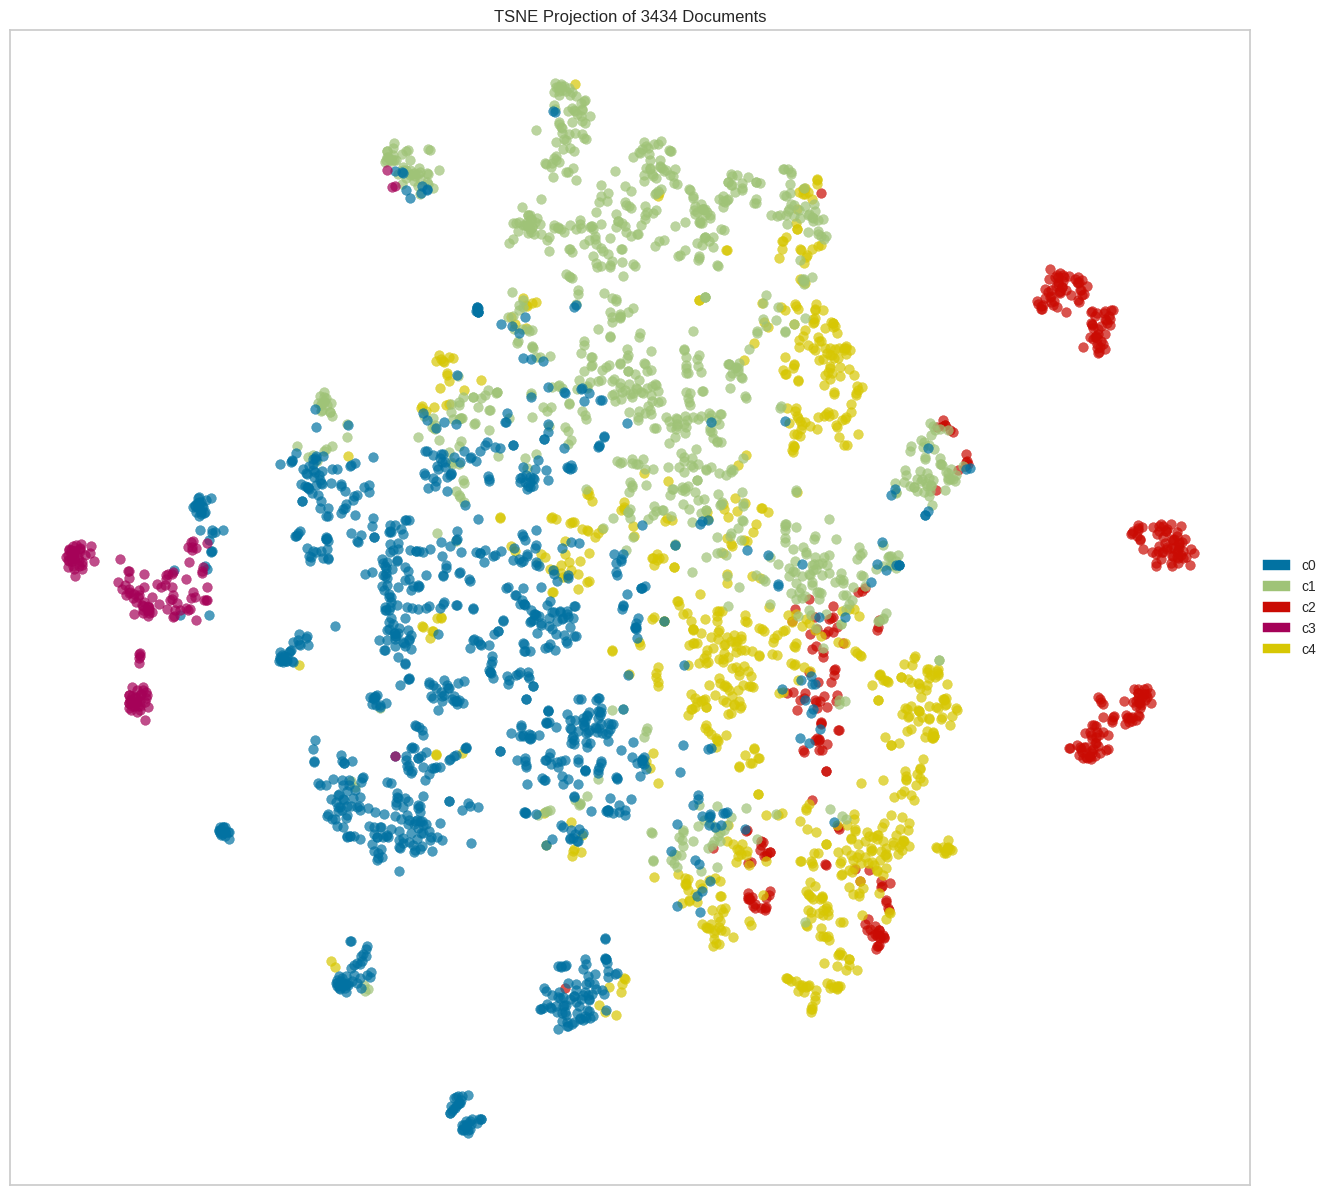

CPU times: user 53.5 s, sys: 1.52 s, total: 55 s
Wall time: 53.4 s


<Axes: title={'center': 'TSNE Projection of 3434 Documents'}>

In [43]:
%%time
from sklearn.cluster import KMeans
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
docs = tfidf.fit_transform(all_speechs_one_list)

# Applying k-means clustering
clusters = KMeans(n_clusters=5)
clusters.fit(docs)
# Applying t-SNE visualization
plt.figure(figsize=(20,15))
tsne = TSNEVisualizer()
tsne.fit(docs, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()

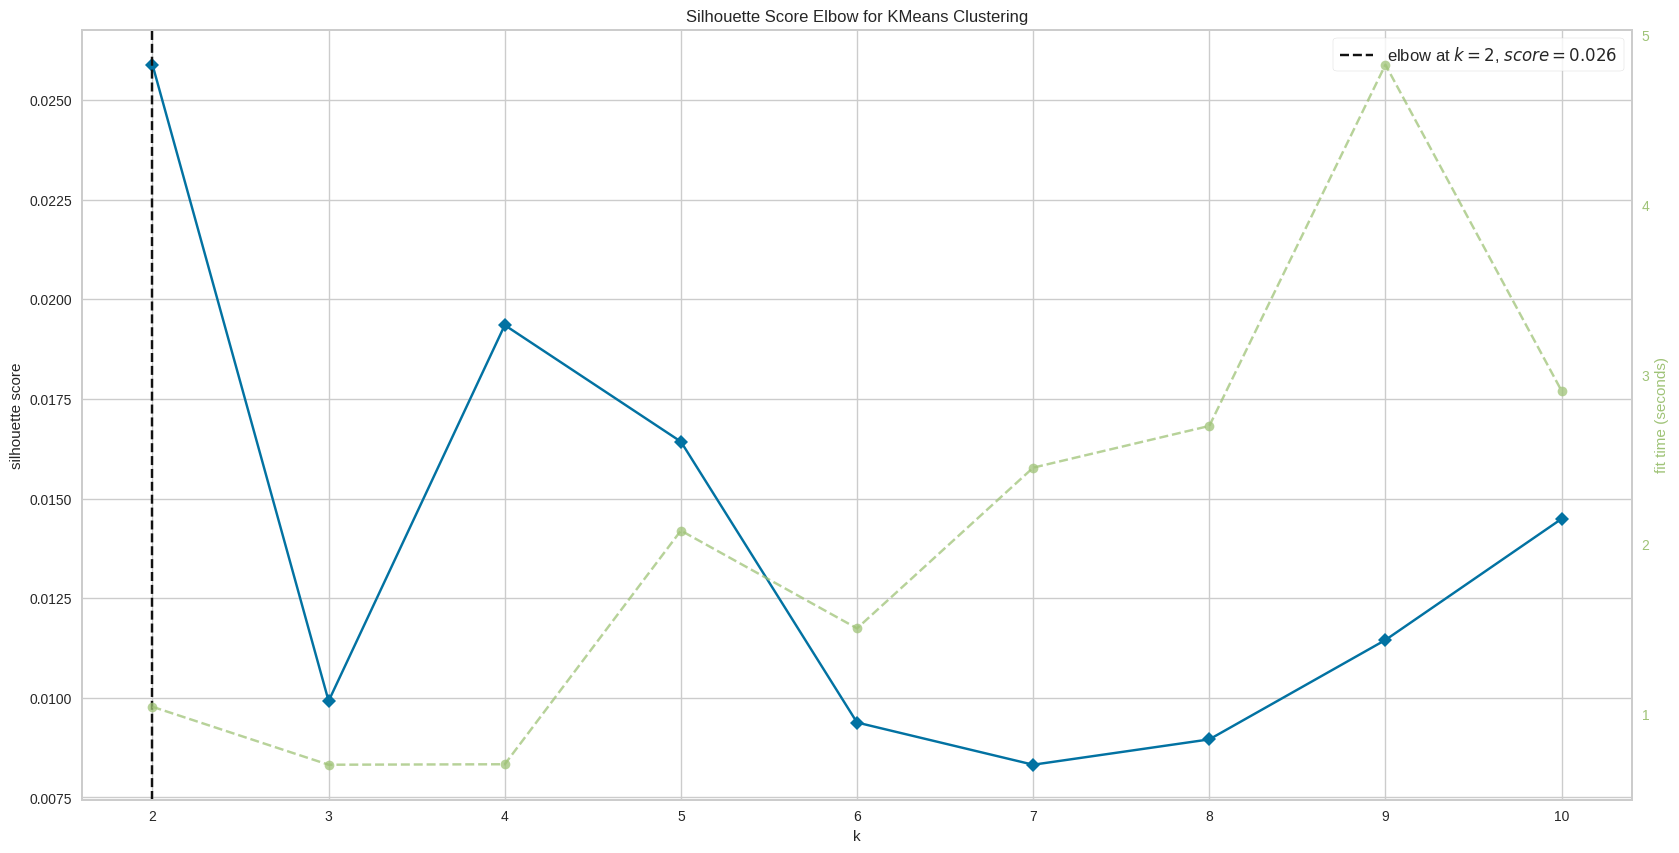

CPU times: user 1min 39s, sys: 1.68 s, total: 1min 41s
Wall time: 1min 42s


<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [44]:
%%time
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
plt.figure(figsize=(20,10))
visualizer = KElbowVisualizer(KMeans(), metric='silhouette', k=list(range(2,11)))
visualizer.fit(docs)
visualizer.poof()

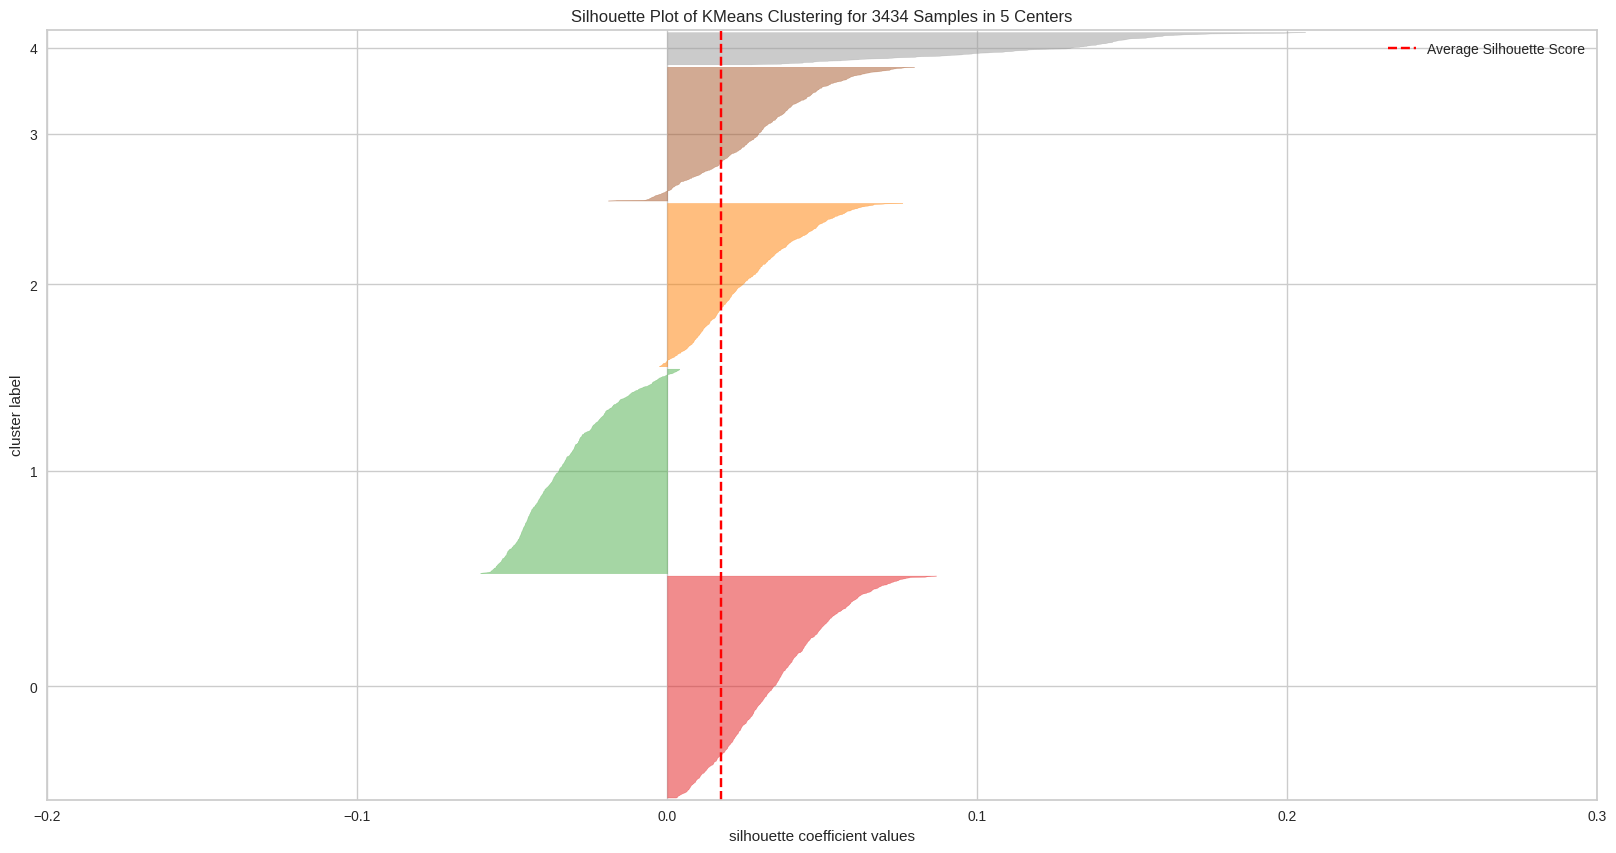

CPU times: user 20 s, sys: 538 ms, total: 20.6 s
Wall time: 20.4 s


<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 3434 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [45]:
%%time
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
plt.figure(figsize=(20,10))
visualizer = SilhouetteVisualizer(KMeans(n_clusters=5))
visualizer.fit(docs)
visualizer.poof()

In [46]:
%%time
from nltk.cluster import KMeansClusterer
from sklearn.base import BaseEstimator, TransformerMixin

class KMeansClusters(BaseEstimator, TransformerMixin):
    def __init__(self, k=7):
        """
        k is the number of clusters model is the implementation of Kmeans
        """
        self.k = k
        self.distance = nltk.cluster.util.cosine_distance
        self.model = KMeansClusterer(self.k, self.distance, avoid_empty_clusters=True)

    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        """
        Fits the K-Means model to one-hot vectorized documents.
        """
        return self.model.cluster(documents, assign_clusters=True)

CPU times: user 482 µs, sys: 0 ns, total: 482 µs
Wall time: 489 µs


In [47]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

class OneHotVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = CountVectorizer(binary=True)

    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        freqs = self.vectorizer.fit_transform(documents)
        return [freq.toarray()[0] for freq in freqs]

In [48]:
from sklearn.pipeline import Pipeline

model = Pipeline([
        #('norm', TextNormalizer()),
        ('vect', OneHotVectorizer()),
        ('clusters', KMeansClusters(k=3))
        ])

clusters = model.fit_transform(normalized_speeches_join)

#for idx, cluster in enumerate(clusters):
#    print("Document '{}' assigned to cluster {}.".format(pickles[idx],cluster))

/usr/local/lib/python3.10/dist-packages/nltk/cluster/util.py:130: RuntimeWarning: invalid value encountered in divide
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))
/usr/local/lib/python3.10/dist-packages/nltk/cluster/util.py:130: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


In [49]:
from collections import Counter

cluster_counts = Counter(clusters)
print("\nNumber of documents in each cluster:")
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} documents")


Number of documents in each cluster:
Cluster 0: 1177 documents
Cluster 1: 1125 documents
Cluster 2: 1132 documents


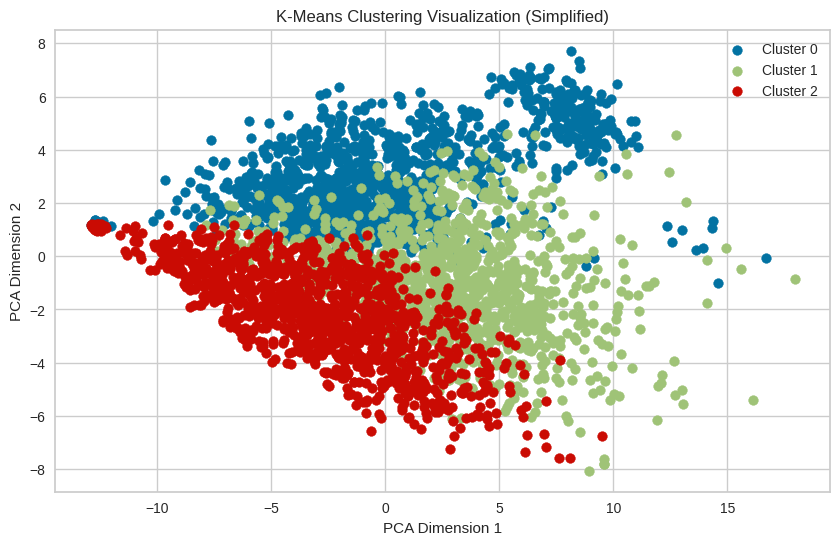

In [50]:
# plot K-means clusters
from sklearn.decomposition import PCA

vectorized_documents = model.named_steps['vect'].vectorizer.fit_transform(normalized_speeches_join).toarray()

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectorized_documents)

cluster_assignments = clusters

plt.figure(figsize=(10, 6))
for cluster_id in np.unique(cluster_assignments):
    cluster_points = reduced_vectors[np.array(cluster_assignments) == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")

plt.title("K-Means Clustering Visualization (Simplified)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

### N-Gram analysis

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

stopwords_list = stopwords.words('english')

# Create a TF-IDF vectorizer object
# TF-IDF (Term Frequency-Inverse Document Frequency) is a technique used to quantify a word in documents
# It is used to reflect how important a word is to a document in a collection or corpus
# The stop_words parameter is used to ignore common words in English such as 'this', 'is', etc.
# The ngram_range parameter is used to specify the size of word chunks to consider as features
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(2,5))

# Create an NMF (Non-Negative Matrix Factorization) object
# The n_components parameter is used to specify the number of topics to extract
nmf = NMF(n_components=3)

# Create a pipeline object that sequentially applies the TF-IDF vectorizer and NMF
pipe = make_pipeline(tfidf_vectorizer, nmf)

def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
%%time
def NMF_fit(data):
    pipe.fit(data)

    # Plot the top words in the topics identified by the NMF model
    plot_top_words(
        nmf, tfidf_vectorizer.get_feature_names_out(), 5
    )

NMF_fit(joined['extracted_text'].dropna().astype(str))

### Deep dive into Speeches & Press releases preceeding a rate change

In [ ]:
direction_increase_df = joined[joined['Direction'] == 'Increase']
direction_decrease_df = joined[joined['Direction'] == 'Decrease']

In [ ]:
freq_distribution(direction_increase_df['extracted_text'].astype(str))

In [ ]:
NMF_fit(direction_increase_df['extracted_text'].astype(str))

In [ ]:
freq_distribution(direction_decrease_df['extracted_text'].astype(str))

In [ ]:
NMF_fit(direction_decrease_df['extracted_text'].astype(str))

## Deep Learning Neural Network - LSTM

In [ ]:
# !pip install keras
# !pip install tensorflow
# !pip install scikeras

In [ ]:
# analyze text lengths
joined['text_length'] = joined['extracted_text'].apply(lambda x: len(word_tokenize(x)))
print(joined['text_length'].describe())

In [ ]:
percentile_95 = joined['text_length'].quantile(0.95)
print(f"95th Percentile of text_length: {percentile_95}")

In [ ]:
import re
import nltk
from nltk.tokenize import sent_tokenize

joined_test = joined[:100]
#joined_test['extracted_text'] = joined_test['extracted_text'].apply(lambda text: re.sub(r'(?<!\s)([.!?])(?=\D)', r'\1 ', text))
joined_test['extracted_text'] = joined_test['extracted_text'].apply(sent_tokenize)
joined_test['extracted_text'].head()

In [ ]:
joined_test['extracted_text'][0]

In [ ]:
num_empty = joined_test['extracted_text'].apply(lambda x: len(x) == 0).sum()
print(f"Number of empty items: {num_empty}")

In [ ]:
for doc in joined_test['extracted_text']:
    assert isinstance(doc, list), f"Document is not a list: {type(doc)}"
    for sent in doc:
        assert isinstance(sent, str), f"Sentence is not a string: {type(sent)}"
print("All documents and sentences are properly structured!")

In [ ]:
import os
import nltk
import gensim
import numpy as np
import unicodedata

from itertools import groupby
from unicodedata import category as unicat

from nltk.corpus import wordnet as wn
from nltk.chunk import tree2conlltags
from nltk.probability import FreqDist
from nltk.chunk.regexp import RegexpParser
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.utils import pad_sequences


class KeyphraseExtractor(BaseEstimator, TransformerMixin):
    """
    Extract adverbial and adjective phrases, and transform
    documents into lists of these keyphrases, with a total
    keyphrase lexicon limited by the nfeatures parameter
    and a document length limited/padded to doclen
    """
    def __init__(self, nfeatures=100000, doclen=7619):
        self.grammar = r'KT: {(<RB.> <JJ.*>|<VB.*>|<RB.*>)|(<JJ> <NN.*>)}'
        # self.grammar = r'KT: {(<RB.*> <VB.>|<RB.>|<JJ.> <NN.*>)}'
        # self.grammar = r'KT: {<RB.>|<JJ.>}'
        self.chunker = RegexpParser(self.grammar)
        self.nfeatures = nfeatures
        self.doclen = doclen

    def normalize(self, sent):
        """
        Removes punctuation from a tokenized/tagged sentence and
        lowercases words.
        """
        is_punct = lambda word: all(unicat(c).startswith('P') for c in word)
        sent = filter(lambda t: not is_punct(t[0]), sent)
        sent = map(lambda t: (t[0].lower(), t[1]), sent)
        return list(sent)

    def extract_candidate_phrases(self, sents):
        """
        For a document, parse sentences using our chunker created by
        our grammar, converting the parse tree into a tagged sequence.
        Extract phrases, rejoin with a space, and yield the document
        represented as a list of it's keyphrases.
        """
        for sent in sents:
            tokens = word_tokenize(sent)
            pos_tags = pos_tag(tokens)
            normalized = self.normalize(pos_tags)
            #print(sent)
            #print(normalized)

            chunks = tree2conlltags(self.chunker.parse(normalized))
            if not chunks or all(chunk[-1] == 'O' for chunk in chunks):
                #print(f"No valid chunks found in sentence: {sent}")
                continue

            phrases = [
                " ".join(word for word, pos, chunk in group).lower()
                for key, group in groupby(
                    chunks, lambda term: term[-1] != 'O'
                ) if key
            ]
            for phrase in phrases:
                yield phrase

    def fit(self, documents, y=None):
        return self

    def get_lexicon(self, keydocs):
        """
        Build a lexicon of size nfeatures
        """
        keyphrases = [keyphrase for doc in keydocs for keyphrase in doc]
        print("Keyphrases:", keyphrases[:5])
        fdist = FreqDist(keyphrases)
        counts = fdist.most_common(self.nfeatures)
        print("Frequency counts:", counts[:5])
        lexicon = [phrase for phrase, count in counts]
        return {phrase: idx+1 for idx, phrase in enumerate(lexicon)}

    def clip(self, keydoc, lexicon):
        """
        Remove keyphrases from documents that aren't in the lexicon
        """
        return [lexicon[keyphrase] for keyphrase in keydoc
            if keyphrase in lexicon.keys()]

    def transform(self, documents):
        docs = [list(self.extract_candidate_phrases(doc)) for doc in documents]
        lexicon = self.get_lexicon(docs)
        clipped = [list(self.clip(doc, lexicon)) for doc in docs]
        return pad_sequences(clipped, maxlen=self.doclen)


In [ ]:
import os
import time
import numpy as np

from functools import wraps

from keras.models import load_model, Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Embedding


N_FEATURES = 10000
DOC_LEN = 7619
N_CLASSES = 3

def build_lstm():
    lstm = Sequential()
    lstm.add(Embedding(input_dim=N_FEATURES + 1, output_dim=128))
    lstm.add(Dropout(0.4))
    lstm.add(LSTM(units=200, recurrent_dropout=0.2, dropout=0.2))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(N_CLASSES, activation='softmax')) # softmax for mult-class classification
    lstm.compile(
        loss='categorical_crossentropy', # target vals are 0, 1 or 2
        optimizer='adam',
        metrics=['accuracy']
    )
    return lstm

In [ ]:
import joblib
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score
from tensorflow.keras.utils import to_categorical

# define the target label mapping
label_mapping = {"No Change": 0, "Increase": 1, "Decrease": 2}

def documents(df):
    texts = df['extracted_text'].values
    return texts

def binarize(df):
    labels = to_categorical(df['Direction'].map(label_mapping).values, num_classes=N_CLASSES)
    return labels

def train_model(df, model, saveto=None, cv=12, **kwargs):
    """
    Trains model from corpus at specified path; fitting the model on the full data and writing it to disk at the saveto directory if specified.
    Returns the scores.
    """
    # Load the corpus data and labels for classification
    X = documents(df)
    print("Shape after tokenization:", len(X))

    y = binarize(df)

    # Compute cross validation scores
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    # Fit the model on entire data set
    model.fit(X, y)

    # Write to disk if specified
    if saveto:
        # have to save the keras part using keras' save method
        model.steps[-1][1].model.save(saveto['keras_model'])
        model.steps.pop(-1)
        # ... and use joblib to save the rest of the pipeline
        joblib.dump(model, saveto['sklearn_pipe'])

    # Return scores as well as training time via decorator
    return scores

In [ ]:
from sklearn.model_selection import train_test_split

X = joined['extracted_text']
y = joined['Direction']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class DebugTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print("Data Shape Before LSTM:", X.shape)
        print("Sample Data Before LSTM:", X[0])  # Print a sample
        return X

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from scikeras.wrappers import KerasClassifier

pipeline = Pipeline([
    ('keyphrases', KeyphraseExtractor(nfeatures=N_FEATURES,
                                      doclen=DOC_LEN)),
    ('debug', DebugTransformer()),
    ('lstm', KerasClassifier(model=build_lstm,
                           epochs=4,
                           batch_size=128))
])

scores, delta = train_model(joined_test, pipeline, cv=4)

print('Mean score: {}'.format(np.mean(scores)))
print('Total fit time: {:0.2f} seconds'.format(delta))